In [1]:
import re
import string
import json
import os
import shutil
from pprint import pprint
from functools import partial
from operator import itemgetter, attrgetter
from os.path import normpath
from typing import Callable

import joblib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from gensim.parsing.preprocessing import STOPWORDS
from sacremoses import MosesTokenizer, MosesTruecaser
from sklearn.base import clone
from sklearn.compose import (
    ColumnTransformer,
    make_column_selector,
    make_column_transformer,
)
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import (
    VarianceThreshold,
    SelectKBest,
    SelectPercentile,
    GenericUnivariateSelect,
    f_classif,
    mutual_info_classif,
    chi2,
)
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier, NearestCentroid, NearestNeighbors
from sklearn.linear_model import (
    LogisticRegression,
    LogisticRegressionCV,
    PassiveAggressiveClassifier,
    Perceptron,
    RidgeClassifier,
    RidgeClassifierCV,
    SGDClassifier,
)
from sklearn.naive_bayes import (
    BernoulliNB,
    CategoricalNB,
    ComplementNB,
    GaussianNB,
    MultinomialNB,
)
from sklearn.svm import LinearSVC, NuSVC, OneClassSVM, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    RepeatedStratifiedKFold,
    StratifiedKFold,
    train_test_split,
)
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.impute import KNNImputer
# from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.preprocessing import (
    OneHotEncoder,
    Binarizer,
    FunctionTransformer,
    MaxAbsScaler,
    MinMaxScaler,
    minmax_scale,
    Normalizer,
    normalize,
    PowerTransformer,
    QuantileTransformer,
    RobustScaler,
    StandardScaler,
    PolynomialFeatures,
    MultiLabelBinarizer,
)
import sklearn.utils as skl_utils
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report
import scipy as sp
import dask
import dask.dataframe as dd
from skmultilearn.adapt import MLkNN

# Set Seaborn theme and default palette
sns.set_theme(font_scale=1.25, style="darkgrid")
sns.set_palette("deep", desat=0.85, color_codes=True)

# Turn on inline plotting
%matplotlib inline

# Load Black auto-formatter
%load_ext nb_black


<IPython.core.display.Javascript object>

In [2]:
# Import my modules
from tools import cleaning, plotting, language as lang, outliers, utils
from tools.sklearn.vectorizers import FreqVectorizer, Doc2Vectorizer, AverageVectorizer
from tools.sklearn import selection

# Run time-consuming grid searches
RUN_SWEEPS = False

# Set my default MPL settings
plt.rcParams.update(plotting.MPL_DEFAULTS)

# Enable automatic reloading
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [3]:
df = pd.read_parquet("data/model_data/main_cat=computers", engine="pyarrow")
display(df.head())
df.shape

,text,title,brand,lang
asin,,,,
0594643058,desktop_dock for samsung_galaxy tab the deskto...,desktop dock for samsung galaxy tab 4,samsung,en
1323549889,the premium cisco ccna home lab kit year_warra...,the premium cisco ccna home lab kit 1-year war...,cisco,en
5720453652,complete handset manager kit bluetooth data su...,complete handset manager kit / bluetooth data ...,samsung,en
7256000073,msata the samsung msata_ssd is built on the cl...,pm841 msata (128gb),samsung,en
7505405403,sony vgp vgp ac_adapter for vaio fz cr series_...,sony vgp-ac19v27 / vgp-ac19v19 19.5v 3.9a ac a...,sony,en


(33888, 4)

<IPython.core.display.Javascript object>

In [4]:
sub_cats = pd.read_parquet("data/amazon_clean", engine="pyarrow", columns=["sub_cat"])
sub_cats = sub_cats.dropna()
sub_cats

,sub_cat
asin,
1441072241,"[books, history, americas, native american]"
6090113980,"[home & kitchen, home dcor, area rugs, runners..."
B00004TUBN,"[home & kitchen, bathroom accessories, holders..."
B00004TUBN,"[home & kitchen, bathroom accessories, holders..."
B000050AP3,"[home & kitchen, heating, cooling & air qualit..."
...,...
B01HHFHGES,"[clothing, shoes & jewelry, women, clothing, t..."
B01HHX5AF2,"[clothing, shoes & jewelry, novelty & more, cl..."
B01HHZYKYW,"[clothing, shoes & jewelry, women, accessories..."


<IPython.core.display.Javascript object>

In [5]:
df = pd.merge(df, sub_cats, left_index=True, right_index=True)
df.head()

,text,title,brand,lang,sub_cat
asin,,,,,
0594643058,desktop_dock for samsung_galaxy tab the deskto...,desktop dock for samsung galaxy tab 4,samsung,en,"[electronics, computers & accessories, tablet ..."
1323549889,the premium cisco ccna home lab kit year_warra...,the premium cisco ccna home lab kit 1-year war...,cisco,en,"[electronics, computers & accessories, network..."
5720453652,complete handset manager kit bluetooth data su...,complete handset manager kit / bluetooth data ...,samsung,en,"[electronics, computers & accessories, compute..."
7256000073,msata the samsung msata_ssd is built on the cl...,pm841 msata (128gb),samsung,en,"[electronics, computers & accessories, data st..."
7505405403,sony vgp vgp ac_adapter for vaio fz cr series_...,sony vgp-ac19v27 / vgp-ac19v19 19.5v 3.9a ac a...,sony,en,"[electronics, computers & accessories, laptop ..."


<IPython.core.display.Javascript object>

In [6]:
del sub_cats

<IPython.core.display.Javascript object>

In [7]:
df = df.explode("sub_cat")
df.head(10)

,text,title,brand,lang,sub_cat
asin,,,,,
0594643058,desktop_dock for samsung_galaxy tab the deskto...,desktop dock for samsung galaxy tab 4,samsung,en,electronics
0594643058,desktop_dock for samsung_galaxy tab the deskto...,desktop dock for samsung galaxy tab 4,samsung,en,computers & accessories
0594643058,desktop_dock for samsung_galaxy tab the deskto...,desktop dock for samsung galaxy tab 4,samsung,en,tablet accessories
0594643058,desktop_dock for samsung_galaxy tab the deskto...,desktop dock for samsung galaxy tab 4,samsung,en,chargers & adapters
1323549889,the premium cisco ccna home lab kit year_warra...,the premium cisco ccna home lab kit 1-year war...,cisco,en,electronics
1323549889,the premium cisco ccna home lab kit year_warra...,the premium cisco ccna home lab kit 1-year war...,cisco,en,computers & accessories
1323549889,the premium cisco ccna home lab kit year_warra...,the premium cisco ccna home lab kit 1-year war...,cisco,en,networking products
1323549889,the premium cisco ccna home lab kit year_warra...,the premium cisco ccna home lab kit 1-year war...,cisco,en,routers
5720453652,complete handset manager kit bluetooth data su...,complete handset manager kit / bluetooth data ...,samsung,en,electronics


<IPython.core.display.Javascript object>

In [8]:
df["sub_cat"] = lang.force_ascii(df.loc[:, "sub_cat"], n_jobs=-1)
df["sub_cat"] = lang.regex_tokenize(
    df.loc[:, "sub_cat"], r"(?i)\b[a-z_]{2,16}\b", n_jobs=-1
).str.join("_")
df["sub_cat"]

asin
0594643058                   electronics
0594643058         computers_accessories
0594643058            tablet_accessories
0594643058             chargers_adapters
1323549889                   electronics
                         ...            
B01HIU3BO6    keyboards_mice_accessories
B01HJ9NROU                   electronics
B01HJ9NROU         computers_accessories
B01HJ9NROU                  data_storage
B01HJ9NROU              usb_flash_drives
Name: sub_cat, Length: 151084, dtype: object

<IPython.core.display.Javascript object>

In [9]:
df = utils.prune_categories(df, "sub_cat", qcut=0.9)
df.sub_cat.value_counts()

                                    Status  Support
electronics                       retained    32145
computers_accessories             retained    31236
computers_tablets                 retained     6409
tablet_accessories                retained     5807
computer_accessories_peripherals  retained     5297
...                                    ...      ...
flash_accessories                  dropped        1
cable_insertion_extraction_tools   dropped        1
smartmedia_cards                   dropped        1
speaker_cables                     dropped        1
wall_stickers_murals               dropped        1

[701 rows x 2 columns]


electronics                         32145
computers_accessories               31236
computers_tablets                    6409
tablet_accessories                   5807
computer_accessories_peripherals     5297
                                    ...  
camera_photo                          152
internal_power_supplies               148
accessory_kits                        144
backpacks                             139
computer_cases                        136
Name: sub_cat, Length: 71, dtype: int64

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='sub_cat', ylabel='Count'>

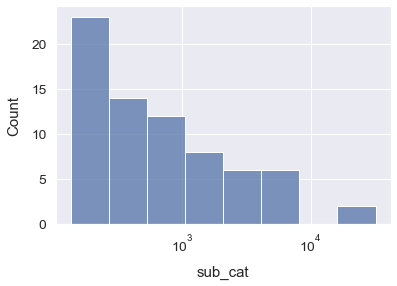

<IPython.core.display.Javascript object>

In [10]:
sns.histplot(data=df.sub_cat.value_counts(), log_scale=True)

In [11]:
df = utils.implode(df, "sub_cat")
df

,text,title,brand,lang,sub_cat
asin,,,,,
0594643058,desktop_dock for samsung_galaxy tab the deskto...,desktop dock for samsung galaxy tab 4,samsung,en,"[electronics, computers_accessories, tablet_ac..."
1323549889,the premium cisco ccna home lab kit year_warra...,the premium cisco ccna home lab kit 1-year war...,cisco,en,"[electronics, computers_accessories, networkin..."
5720453652,complete handset manager kit bluetooth data su...,complete handset manager kit / bluetooth data ...,samsung,en,"[electronics, computers_accessories, computer_..."
7256000073,msata the samsung msata_ssd is built on the cl...,pm841 msata (128gb),samsung,en,"[electronics, computers_accessories, data_stor..."
7505405403,sony vgp vgp ac_adapter for vaio fz cr series_...,sony vgp-ac19v27 / vgp-ac19v19 19.5v 3.9a ac a...,sony,en,"[electronics, computers_accessories, laptop_ac..."
...,...,...,...,...,...
B01HIJIZR0,high_performance flagship toshiba fhd ips touc...,2016 high performance flagship toshiba fhd ips...,toshiba,en,"[electronics, computers_accessories, computers..."
B01HISY3U4,vangoddy plum purple shock_absorbent sleeve fi...,vangoddy plum purple shock absorbent sleeve fi...,vangoddy,en,"[electronics, computers_accessories, laptop_ac..."
B01HISY480,vangoddy charcoal_gray shock_absorbent sleeve ...,vangoddy charcoal gray shock absorbent sleeve ...,vangoddy,en,"[electronics, computers_accessories, laptop_ac..."


<IPython.core.display.Javascript object>


# Modeling
## Train-Test Split

In [12]:
mlb = MultiLabelBinarizer()

<IPython.core.display.Javascript object>

In [13]:
# Define X and y
X = df.loc[:, ["text", "brand"]].sample(frac=0.25, random_state=303)
y = df.loc[X.index, "sub_cat"]
y = mlb.fit_transform(y)

<IPython.core.display.Javascript object>

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6219, 2), (2074, 2), (6219, 71), (2074, 71))

<IPython.core.display.Javascript object>

In [15]:
mlb.classes_

array(['accessories', 'accessories_supplies', 'accessory_kits',
       'all_in_ones', 'audio_video_accessories', 'backpacks',
       'bags_cases_sleeves', 'batteries', 'cables_interconnects',
       'camera_photo', 'cases', 'cases_holsters_sleeves', 'cat_cables',
       'cell_phones_accessories', 'chargers_adapters',
       'computer_accessories_peripherals', 'computer_cable_adapters',
       'computer_cases', 'computer_components', 'computers_accessories',
       'computers_tablets', 'connectors_adapters', 'cpu_processors',
       'data_storage', 'desktops', 'electronics', 'ethernet_cables',
       'external_components', 'external_hard_drives', 'fans_cooling',
       'folio_cases', 'graphics_cards', 'hard_drive_accessories',
       'hard_drive_enclosures', 'in_laptops', 'internal_components',
       'internal_hard_drives', 'internal_power_supplies',
       'internal_solid_state_drives', 'keyboard_cases', 'keyboards',
       'keyboards_mice_accessories', 'laptop_accessories',
       'l

<IPython.core.display.Javascript object>

In [16]:
fv = FreqVectorizer(
    lowercase=False,
    decode_html_entities=False,
    token_pattern=r"(?i)\b[a-z_]{2,16}\b",
)

ohe = OneHotEncoder(handle_unknown="ignore")

fv, ohe

(FreqVectorizer(decode_html_entities=False, lowercase=False,
                token_pattern='(?i)\\b[a-z_]{2,16}\\b'),
 OneHotEncoder(handle_unknown='ignore'))

<IPython.core.display.Javascript object>

In [17]:
ct = ColumnTransformer(
    [
        ("text", fv, "text"),
        ("brand", ohe, ["brand"]),
    ],
)
ct

ColumnTransformer(transformers=[('text',
                                 FreqVectorizer(decode_html_entities=False,
                                                lowercase=False,
                                                token_pattern='(?i)\\b[a-z_]{2,16}\\b'),
                                 'text'),
                                ('brand',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['brand'])])

<IPython.core.display.Javascript object>

In [18]:
# rf = RandomForestClassifier(class_weight="balanced", n_jobs=-1)
# rf

<IPython.core.display.Javascript object>

In [38]:
from skmultilearn.adapt import BRkNNaClassifier, BRkNNbClassifier

knn = MLkNN(k=3)
knn

MLkNN(k=3)

<IPython.core.display.Javascript object>

In [39]:
pipe = Pipeline(
    [
        ("vec", ct),
        ("cls", knn),
    ],
    verbose=True,
)
pipe

Pipeline(steps=[('vec',
                 ColumnTransformer(transformers=[('text',
                                                  FreqVectorizer(decode_html_entities=False,
                                                                 lowercase=False,
                                                                 token_pattern='(?i)\\b[a-z_]{2,16}\\b'),
                                                  'text'),
                                                 ('brand',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['brand'])])),
                ('cls', MLkNN(k=3))],
         verbose=True)

<IPython.core.display.Javascript object>

# Baseline RF

In [40]:
def get_report(estimator, X_test=X_test, y_test=y_test, target_names=mlb.classes_):
    report = classification_report(
        y_test,
        estimator.predict(X_test),
        target_names=target_names,
        output_dict=True,
    )
    report = pd.DataFrame(report).T
    report.loc["accuracy", "support"] = report["support"].max()
    return report

<IPython.core.display.Javascript object>

In [41]:
pipe.fit(X_train, y_train)

[Pipeline] ............... (step 1 of 2) Processing vec, total=   0.8s


C:\Users\ndgig\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_neighbors=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


[Pipeline] ............... (step 2 of 2) Processing cls, total=  11.2s


Pipeline(steps=[('vec',
                 ColumnTransformer(transformers=[('text',
                                                  FreqVectorizer(decode_html_entities=False,
                                                                 lowercase=False,
                                                                 token_pattern='(?i)\\b[a-z_]{2,16}\\b'),
                                                  'text'),
                                                 ('brand',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['brand'])])),
                ('cls', MLkNN(k=3))],
         verbose=True)

<IPython.core.display.Javascript object>

In [42]:
get_report(pipe)

,precision,recall,f1-score,support
accessories,0.593750,0.263889,0.365385,72.0
accessories_supplies,0.210526,0.250000,0.228571,32.0
accessory_kits,0.000000,0.000000,0.000000,8.0
all_in_ones,0.666667,0.347826,0.457143,23.0
audio_video_accessories,0.270270,0.238095,0.253165,42.0
...,...,...,...,...
micro avg,0.822511,0.773401,0.797200,8910.0
macro avg,0.644001,0.479594,0.522653,8910.0
weighted avg,0.816115,0.773401,0.785255,8910.0
samples avg,0.826393,0.763083,0.775412,8910.0


<IPython.core.display.Javascript object>

In [35]:
br_grid = {"k": sp.stats.randint(3, 100)}
br_grid

{'k': <scipy.stats._distn_infrastructure.rv_frozen at 0x1d029192eb0>}

<IPython.core.display.Javascript object>

In [36]:
gs = selection.sweep(
    pipe,
    br_grid,
    X=X_train,
    y=y_train,
    kind="rand",
    n_iter=10,
    scoring="f1_macro",
    add_prefix="cls__",
    n_jobs=-1,
)
gs

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=Pipeline(steps=[('vec',
                                              ColumnTransformer(transformers=[('text',
                                                                               FreqVectorizer(decode_html_entities=False,
                                                                                              lowercase=False,
                                                                                              token_pattern='(?i)\\b[a-z_]{2,16}\\b'),
                                                                               'text'),
                                                                              ('brand',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['brand'])])),
                                             ('cls', MLkNN())],
                                      v

<IPython.core.display.Javascript object>

In [37]:
br_results = selection.prune_cv(gs.cv_results_)
br_results.head(10)

,k,params,mean_fit_time,mean_score,rank_score
0,3,{'cls__k': 3},18.701999,0.520348,1
1,4,{'cls__k': 4},16.793429,0.507818,2
2,4,{'cls__k': 4},17.990399,0.507818,2
3,12,{'cls__k': 12},20.569599,0.450585,4
4,19,{'cls__k': 19},22.804614,0.424999,5
5,24,{'cls__k': 24},23.484211,0.409871,6
6,50,{'cls__k': 50},29.706999,0.338810,7
7,53,{'cls__k': 53},30.646198,0.329794,8
8,62,{'cls__k': 62},34.589999,0.317530,9
9,79,{'cls__k': 79},38.156600,0.302777,10


<IPython.core.display.Javascript object>